# Objective

We will investigate the data

# Import libraries, paths and tools

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import random
pd.options.display.float_format = '{:.2f}'.format

In [121]:
#data repository
data_dir = Path(r'/Users/michaelargi/projects/perso/unsupervised')
folder_path = os.path.join(data_dir, 'ML_Export_rlv')

data_paths = {
    'combined_data':'combined_data.csv',
    'combined_data_agregatedAppareil':'combined_data_appareil.csv',
    'anomalies':'EXPORT_ml_ANO_233.csv',
    'combined_data_Adjusted_Index_Change':'consolidated_with_Adjusted_Index_Change.csv',
    'data':'RLV_YY_2018_to_2024.xlsx',
    'train':'train.csv',
    'test':'test.csv',
    'validation':'validation.csv',
    'cleaned':'tmp/data_cleaned.csv',
    'ready':'tmp/data_ready.csv',
    'X_train':'tmp/train_features.csv',
    'y_train':'tmp/train_target.csv',
    'X_val':'tmp/val_features.csv',
    'y_val':'tmp/val_target.csv',
    'X_train_processed':'tmp/train_features_processed.csv',
    'X_val_processed':'tmp/val_features_processed.csv',
    'check':'tmp/check.csv',
    'dayoffs':'DAY_OFFS.csv'
}



In [122]:
class Environment:
    target_column_name = "Revised"
    should_rename_columns= False
    should_bin=False
    num_bins = 5
    nb_binning_limit = 20
    binned_suffix = "_BINNED"
    show_graphs = False
    should_normalize = False
    final_normalization= False
    def todict(self):
      return{
          "target_column_name":self.target_column_name,
          "should_rename_columns":self.should_rename_columns,
          "should_bin":self.should_bin,
          "num_bins":self.num_bins,
          "nb_binning_limit": self.nb_binning_limit,
          "binned_suffix" :self.binned_suffix,
          "show_graphs" :self.show_graphs,
          "should_normalize" :self.should_normalize,
          "final_normalization": self.final_normalization
      }


ENV= Environment()


In [123]:
import csv,json
from datetime import datetime

def create_result_folder():
  prefix="results_"
  now = datetime.now()
  time_str = now.strftime("%Y%m%d_%H%M%S")
  folder_name = f"{prefix}{time_str}"
  folder_path = os.path.join(data_dir, folder_name)
  os.mkdir(folder_path)
  return folder_path

#folder_path=create_result_folder()

#save dict in file
def saveDictInFile(dict, file_name):
    print("saveDictInFile")
    os.makedirs(folder_path, exist_ok=True)
    csv_file_path = os.path.join(folder_path, file_name)
    with open(csv_file_path, "w", newline="") as fp:
      writer = csv.DictWriter(fp, fieldnames=dict.keys())
      writer.writeheader()
      writer.writerow(dict)

#save list in file
def write_list(a_list,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df = pd.DataFrame(a_list)
  dataframe_to_csv(df,csv_file_path)

#Save dataframe to csv
def dataframe_to_csv(df,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df.to_csv(csv_file_path, index=False)

def generate_name_based_on_time(prefix="Name_", suffix=""):
    now = datetime.now()
    time_str = now.strftime("%Y%m%d_%H%M%S")
    name = f"{prefix}{time_str}{suffix}"
    return name

saveDictInFile(ENV.todict(),"env.csv")

#result_file_name = "results.csv"

saveDictInFile


In [124]:
#utils
def encode_columns(data_frame, verbose=False):
  #Encoding
  label_encoder = LabelEncoder()
  for column in data_frame.columns:
      if column == ENV.target_column_name:
        data_frame[ENV.target_column_name] = data_frame[ENV.target_column_name].astype(int)
        if verbose:
          print("Don't encode target, we convert to int")
        continue
      if data_frame[column].dtype == 'object':  # Check if the column is of type 'object' (string)
          data_frame[column] = label_encoder.fit_transform(data_frame[column])
      elif data_frame[column].dtype == 'bool':
          data_frame[column].replace({True: 1, False: 0},inplace=True)
      else:
        if verbose:
          print("encode_columns error "+column+" ")
        #print(data_frame[column].dtype)


def drop_columns(data_frame,columns_to_drop):
  data_frame_copy = data_frame.copy()
  for column in columns_to_drop:
    if column in data_frame_copy.columns:
        print("dropping column")
        data_frame_copy.drop(columns=column, inplace=True)
    else:
        print(f"Column '{column}' does not exist in the DataFrame.")
  return data_frame_copy

In [125]:
def is_key_column(col):
  nb_unique_values = col.nunique()
  return nb_unique_values>100 and  nb_unique_values/col.count()>0.7

def is_binnable(col,nb_bins):
  nb_unique_values = col.nunique()
  return nb_unique_values>nb_bins and nb_unique_values> ENV.nb_binning_limit

def normalize(df:pd.DataFrame, col_name:str, factor):
  min = df[col_name].min()
  max = df[col_name].max()
  df[col_name]=(df[col_name]-min)/(max - min) * factor

#Clear folder's content, delete all file inside
def clear_folder(folder_path):
  files = os.listdir(folder_path)
  for file in files:
      file_path = os.path.join(folder_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)



In [126]:
#binning
from sklearn.tree import DecisionTreeRegressor

def create_bin_column(df:pd.DataFrame,column:str,num_bins:int, optional_bin_edges = None, verbose = False):
  if column == ENV.target_column_name:
    return

  if verbose:
    print("binning "+column)
  col = df[column]
  target_column_name= ENV.target_column_name
  target = df[target_column_name]
  if verbose:
    print("min",col.min())
    print("max",col.max())
  if col.nunique() <= num_bins:
    if verbose:
      print("too few for binning, returning")
    return
  if(optional_bin_edges):
    bin_edges = optional_bin_edges
  else:
    nb_leaves= num_bins
    tree = DecisionTreeRegressor(max_leaf_nodes=nb_leaves )
    tree.fit(df[[column]], target)

    # Use the decision tree to assign each data point to a bin
    bin_edges = tree.tree_.threshold[tree.tree_.feature != -2]

    # You might want to add the minimum and maximum edges
    bin_edges = np.concatenate(([col.min()], bin_edges, [col.max()]))
    if verbose:
      print(bin_edges)

    # Sort the array to ensure correct order of bin edges
    bin_edges.sort()

  # Print bin edges
  if verbose:
    print("Bin edges:", bin_edges)

  df[column + ENV.binned_suffix] = pd.cut(df[column], bins=bin_edges, include_lowest=True, labels=range(num_bins))

  return bin_edges


In [127]:
def transform_column_name(name):
    # Remove trailing spaces, replace special characters with underscores, and convert to capital letters
    return name.strip().replace(' ', '_').replace('@', '_').upper()

# Function to get specific data and format if needed

In [128]:
def get_combined_df(regenerate = False):
    
    export_path = folder_path+'/'+data_paths['combined_data']
    columns_to_drop=['Unitee']
    dtype_spec = {'Region': str,'Code_Naf':str}
    def export_releves():
        column_name_mapping = {
            'ABLBELNR': 'Releve',
            'GERNR': 'Appareil',
            'EQUNR': 'Equipement',
            'ZWNUMMER': 'Cadran',
            'ADAT': 'Date_de_releve',
            'V_ZWSTAND': 'Index',
            'MASSREAD': 'Unitee',
            'ANLAGE': 'Installation',
            'REGIOGROUP': 'Region',
            'IND_SECTOR': 'Code_Naf'
        }
        data_frames = []
        print(folder_path)
        for filename in os.listdir(folder_path):
            print(filename)
            if filename.endswith('.xlsx') or filename.endswith('.XLSX'):
                print("adding "+filename)
                file_path = os.path.join(folder_path, filename)
                df = pd.read_excel(file_path)
                df.columns = df.columns.str.replace(' ', '', regex=False)
                df = drop_columns(df,columns_to_drop)
                if set(column_name_mapping.keys()).intersection(df.columns):
                    df.rename(columns=column_name_mapping, inplace=True)
                data_frames.append(df)
                _combined_df = pd.concat(data_frames, ignore_index=True)
        dataframe_to_csv(_combined_df,data_paths['combined_data'])
        return _combined_df
        
    if os.path.isfile(export_path) and not regenerate:
        combined_df = pd.read_csv(export_path,dtype=dtype_spec,low_memory=False)
        combined_df = drop_columns(combined_df,columns_to_drop)
    else:
        combined_df = export_releves()
    combined_df['Date_de_releve'] = pd.to_datetime(combined_df['Date_de_releve'], format='%Y%m%d')
    combined_df.sort_values(by=['Appareil','Cadran', 'Date_de_releve'], inplace=True)
    return combined_df

releves_df = get_combined_df()
releves_df['Cadran_key'] = releves_df['Installation'].astype(str) + "_" + releves_df['Cadran'].astype(str)

print(releves_df.columns)
print(releves_df.dtypes)


dropping column
Index(['Releve', 'Appareil', 'Equipement', 'Cadran', 'Date_de_releve', 'Index',
       'Installation', 'Region', 'Code_Naf', 'Cadran_key'],
      dtype='object')
Releve                     int64
Appareil                   int64
Equipement                 int64
Cadran                     int64
Date_de_releve    datetime64[ns]
Index                      int64
Installation               int64
Region                    object
Code_Naf                  object
Cadran_key                object
dtype: object


In [129]:
def get_anomalies():
    dtype_spec = {'IDPtLvrsn': str}
            
    anomalies_path = os.path.join(data_dir, data_paths['anomalies'])
    columns_to_drop=['ConsCli.','Cdeachat']
    anomalies_df = pd.read_csv(anomalies_path,dtype=dtype_spec,low_memory=False)
    anomalies_df.columns = anomalies_df.columns.str.replace(' ', '', regex=False)
    anomalies_df = drop_columns(anomalies_df,columns_to_drop)
    print(anomalies_df.columns)
    return anomalies_df



#anomalies_df=get_anomalies()


In [130]:

def get_aggregated_data():
    path = os.path.join(folder_path,data_paths['combined_data_agregatedAppareil'])
    print(path)
    isFile = os.path.isfile(path) 
    if isFile:
        aggregated_data = pd.read_csv(path)
    else:
        print("aggregating")
        aggregated_data = releves_df.groupby(['Appareil', 'Date_de_releve']).agg(
            AggregatedIndex=pd.NamedAgg(column='Index', aggfunc='sum'),
            nbCadrans=pd.NamedAgg(column='Cadran', aggfunc=lambda x: x.nunique())
        ).reset_index()
        print("exporting")
        dataframe_to_csv(aggregated_data,data_paths['combined_data_agregatedAppareil'])
    return aggregated_data

aggregated_data = get_aggregated_data()
print(aggregated_data.columns)


/Users/michaelargi/projects/perso/unsupervised/ML_Export_rlv/combined_data_appareil.csv
Index(['Appareil', 'Date_de_releve', 'AggregatedIndex', 'nbCadrans'], dtype='object')


In [131]:
def add_change_column(df):
    print("started")
    df.sort_values(by=['Cadran_key', 'Date_de_releve'], inplace=True)

    # Calculate the difference in days between successive Date_de_releve entries
    df['Time_diff'] = df.groupby('Cadran_key')['Date_de_releve'].diff().dt.days

    df['Index_change'] = df.groupby('Cadran_key')['Index'].diff()
    # Calculate the percentage change of the Index
    df['Index_pct_change'] = df.groupby('Cadran_key')['Index'].pct_change() * 100

    # Adjust the Index Percentage Change by the Time Difference
    df['Adjusted_Index_Change'] = df['Index_pct_change'] / df['Time_diff']
    return df

def get_aggregated_data_with_Adjusted_Index_Change():
    path = os.path.join(folder_path,data_paths['combined_data_Adjusted_Index_Change'])
    print(path)
    isFile = os.path.isfile(path) 
    if isFile:
        aggregated_data = pd.read_csv(path)
    else:
        print("aggregating")
        aggregated_data = add_change_column(releves_df)
        dataframe_to_csv(aggregated_data,data_paths['combined_data_Adjusted_Index_Change'])
        print("produced")
    return aggregated_data

#wazza = get_aggregated_data_with_Adjusted_Index_Change()

In [132]:
def get_releve_info(df, releve):
    filtered_rows = df[df['Releve'] == releve]
    return filtered_rows

# First view of data



In [133]:
consolidated_df = releves_df

show_describe= False
need_sorting = False
check_matching = False

if ENV.should_rename_columns:
  consolidated_df.rename(columns=transform_column_name, inplace=True)
  ENV.target_column_name = ENV.target_column_name.upper()

if show_describe:
    print('This is the Shape of the data')
    print('='*49)
    print("The total number of columns: ", consolidated_df.shape[1])
    print("The total number of rows: ", consolidated_df.shape[0])
    print('='*49)

    print('\nTypes of the Dataset:')
    print("=" * 40)
    print(consolidated_df.dtypes)

    print('\nDescription of the numerical Dataset:')
    print("=" * 40)
    numerical_description = consolidated_df.describe(include=['int', 'float']).T
    print(numerical_description)

    print('\nDescription of the Categorical Dataset:')
    print("=" * 40)
    #categorical_description = df.describe(include=['object', 'bool']).T
    #categorical_description = df.describe(include='all').T
    categorical_description = consolidated_df.describe(include=['object', 'bool']).T
    print(categorical_description)

    print('\nDescription of the nb values:')
    print("=" * 40)
    value_counts_per_column = consolidated_df.nunique()

    # Convert the Series to a DataFrame for better table display
    value_counts_df = value_counts_per_column.reset_index()
    print(value_counts_df)

    # Define a styling function
    def style_description(s):
        return f'background-color: lightblue; font-weight: bold;'

    # Apply the styling to the DataFrame
    styled_description = categorical_description.style.applymap(style_description)
    styled_description
    #print(styled_description)

    print("\nis null")
    print("=" * 40)
    print(consolidated_df.isnull().sum())

    print("\nhead")
    print("=" * 40)
    consolidated_df.head()


if False:
    print("=" * 40)
    print("One to One correspondances")
    print("=" * 40)
    appareil_equipement =consolidated_df.drop_duplicates(subset=['Appareil', 'Equipement'])
    appareil_to_equipement_unique = appareil_equipement.groupby('Appareil').size().max() > 1
    print(f"Can appareil be linked to more than one Equipement: {appareil_to_equipement_unique}")
    equipement_to_appareil_unique = appareil_equipement.groupby('Equipement').size().max() > 1
    print(f"Can Equipement be linked to more than one appareil: {equipement_to_appareil_unique}")

    installation_equipement =consolidated_df.drop_duplicates(subset=['Installation', 'Equipement'])
    installation_to_equipement_unique = installation_equipement.groupby('Equipement').size().max() > 1
    print(f"Can Equipement be linked to more than one Installation: {installation_to_equipement_unique}")
    equipement_to_installation_unique = installation_equipement.groupby('Installation').size().max() > 1
    print(f"Can Installation be linked to more than one Equipement: {equipement_to_installation_unique}")

    installation_appareil =consolidated_df.drop_duplicates(subset=['Installation', 'Appareil'])
    installation_to_appareil_unique = installation_appareil.groupby('Appareil').size().max() > 1
    print(f"Can Appareil be linked to more than one Installation: {installation_to_appareil_unique}")
    appareil_to_installation_unique = installation_appareil.groupby('Installation').size().max() > 1
    print(f"Can Installation be linked to more than one Appareil: {appareil_to_installation_unique}")

    print("Finally : an Installation has one to many with Appareil and Equipement")
    print("But many to many Installation=Appareil ?")

if check_matching:
    print("=" * 40)
    print("Check Releves matching")
    print("=" * 40)
    if anomalies_df is None:
        anomalies_df = get_anomalies()
    first_100_releve_values = anomalies_df['Releve'].head(100)

    count=0
    cadran_anomalies={}
    for r in first_100_releve_values:
        match = consolidated_df.loc[consolidated_df['Releve'] == r]
        if not match.empty:
            count+=1
            #print(match)
            cadran_key = str(match['Cadran_key'].iloc[0])
            cadran_anomalies[r]=cadran_key

    print(f"nb Found Anomalie releves in 100 releves: {count}")

    #now I want the matched anomalies where Date_releve is not the first of consolidated_df
    first_1000_releve_values = anomalies_df['Releve'].head(1000)
    count=0
    cadran_anomalies_not_first_releve={}
    if need_sorting:
        df_sorted = consolidated_df.sort_values(by=['Installation', 'Cadran_key', 'Date_de_releve'])
    else:
        df_sorted = consolidated_df

    print("removing first occurence of Date_de_releve")
    #df_filtered = df_sorted[df_sorted.groupby(['Installation', 'Cadran_key']).cumcount() > 0]
    df_filtered = df_sorted[df_sorted.groupby(['Cadran_key']).cumcount() > 0]

    print(df_filtered.head())

    index=0
    for r in first_1000_releve_values:
        index+=1
        if index%100==0:
            print(index)
        match = df_filtered.loc[consolidated_df['Releve'] == r]
        if not match.empty:
            count+=1
            #print(match)
            print(r)
            cadran_key = str(match['Cadran_key'].iloc[0])
            cadran_anomalies_not_first_releve[r]=cadran_key

    print(f"nb Found Anomalie releves in 1000 releves, ignoring first Date_de_releve: {count}")
    for key, value in cadran_anomalies_not_first_releve.items():
        print(key)
        print(value)
        plot_index_per_date_for_Cadran(consolidated_df,value)




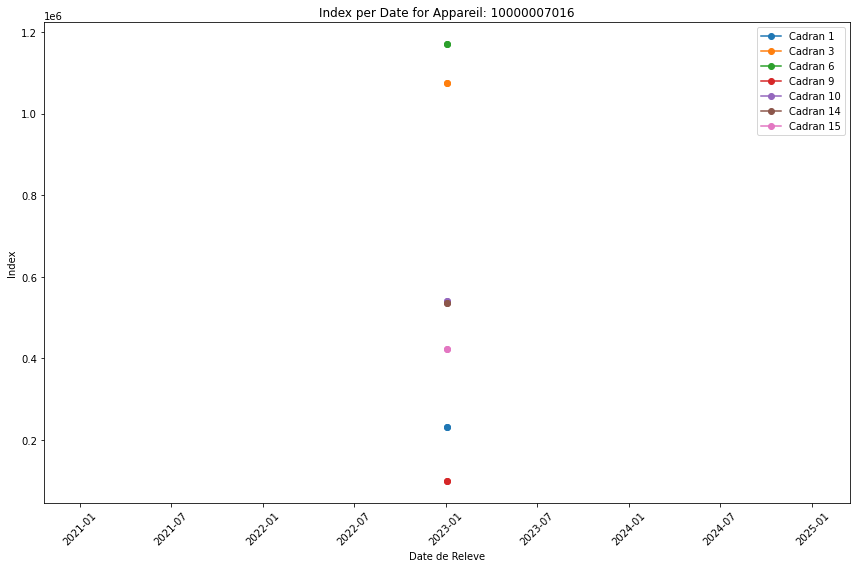

In [134]:
def plot_index_per_date_for_appareil(df, appareil):
    # Filter DataFrame based on the 'Appareil' value
   
    filtered_df = df[df['Appareil'] == appareil]
    
    # Get unique 'Cadran' values
    cadran_values = filtered_df['Cadran'].unique()
    
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    
    # Loop through each 'Cadran' value and plot
    for cadran in cadran_values:
        subset_df = filtered_df[filtered_df['Cadran'] == cadran]
        plt.plot(subset_df['Date_de_releve'], subset_df['Index'], marker='o', label=f'Cadran {cadran}')
    
    plt.title(f'Index per Date for Appareil: {appareil}')
    plt.xlabel('Date de Releve')
    plt.ylabel('Index')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_index_per_date_for_appareil(consolidated_df,10000007016)

def plot_index_per_date_for_installation(df, installation,saveName=""):
    filtered_df = df[df['Installation'] == installation]
    # Get unique 'Cadran' values
    cadran_values = filtered_df['Cadran'].unique()
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    # Loop through each 'Cadran' value and plot
    for cadran in cadran_values:
        subset_df = filtered_df[filtered_df['Cadran'] == cadran]
        plt.plot(subset_df['Date_de_releve'], subset_df['Index'], marker='o', label=f'Cadran {cadran}')
    
    plt.title(f'Index per Date for Installation: {installation}')
    plt.xlabel('Date de Releve')
    plt.ylabel('Index')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    if saveName:
        plt.savefig(saveName)
        plt.close()
    else:
        plt.show()


#plot_index_per_date_for_installation(consolidated_df,495250)

def plot_index_per_date_for_Cadran(df, cadran_key):
    cadran_key = str(cadran_key)
    specific_cadran_df = df[df['Cadran_key'] == cadran_key]
    plt.figure(figsize=(10, 6))
    plt.plot(specific_cadran_df['Date_de_releve'], specific_cadran_df['Index'], marker='o')
    plt.title(f'Index vs Date_de_releve for Cadran_key {cadran_key}')
    plt.xlabel('Date_de_releve')
    plt.ylabel('Index')
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.tight_layout()
    plt.show()
    
#plot_index_per_date_for_Cadran(consolidated_df,'41036885728_1')
    


def print_Date_de_Releve_for_Cadran_key(df, specific_cadran_key):
    filtered_df = df[df['Cadran_key'] == specific_cadran_key]
    print(filtered_df['Date_de_releve'])
    
#print_Date_de_Releve_for_Cadran_key(consolidated_df,'41036856101_1')


    


# Analysis

/Users/michaelargi/projects/perso/unsupervised/ML_Export_rlv/consolidated_with_Adjusted_Index_Change.csv
Index(['Releve', 'Appareil', 'Equipement', 'Cadran', 'Date_de_releve', 'Index',
       'Installation', 'Region', 'Code_Naf', 'Cadran_key', 'Index_pct_change',
       'Time_diff', 'Index_change', 'Adjusted_Index_Change'],
      dtype='object')
Nb significant_changes:27375
 Releve 4192490515 and Cadran 1000198_2 and Installation 1000198


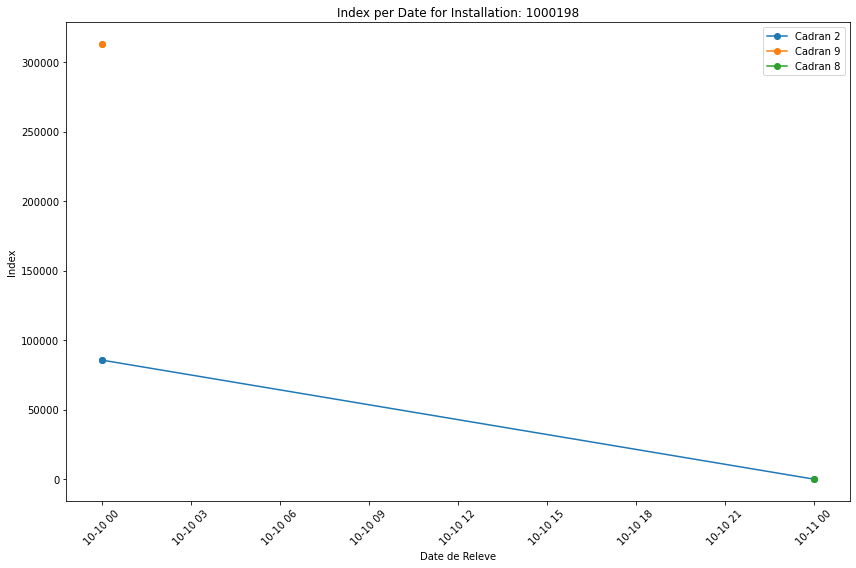

******************************
          Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
1303  4192490515  41036940763     2690039       2     2023-10-11      0       1000198    197    0322Z  1000198_2           -100.00       1.00     -85638.00                -100.00
------------------------------
 Releve 4287151939 and Cadran 100051_3 and Installation 100051


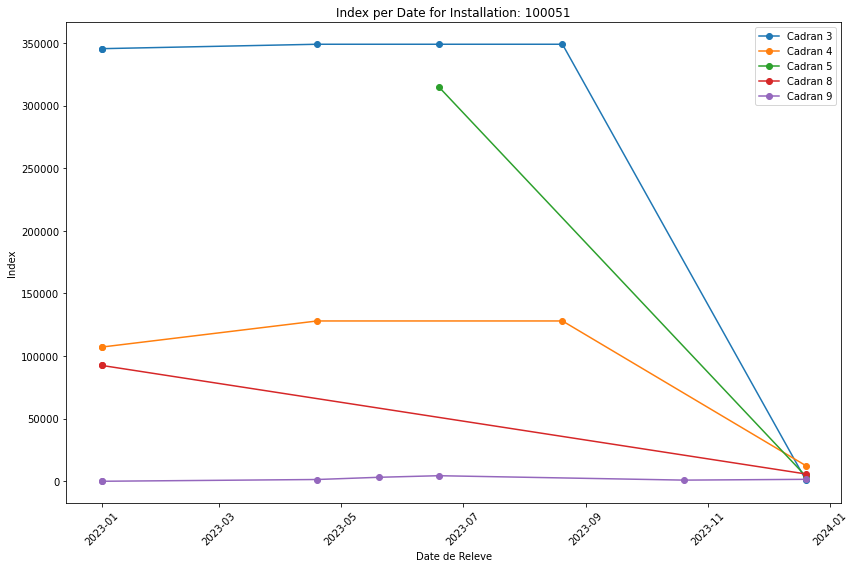

******************************
          Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
2180  4287151939  41036937540     2684968       3     2023-12-20   1120        100051    055    8411Z   100051_3            -99.68     122.00    -347839.00                  -0.82
------------------------------
 Releve 4092261603 and Cadran 1000713_1 and Installation 1000713


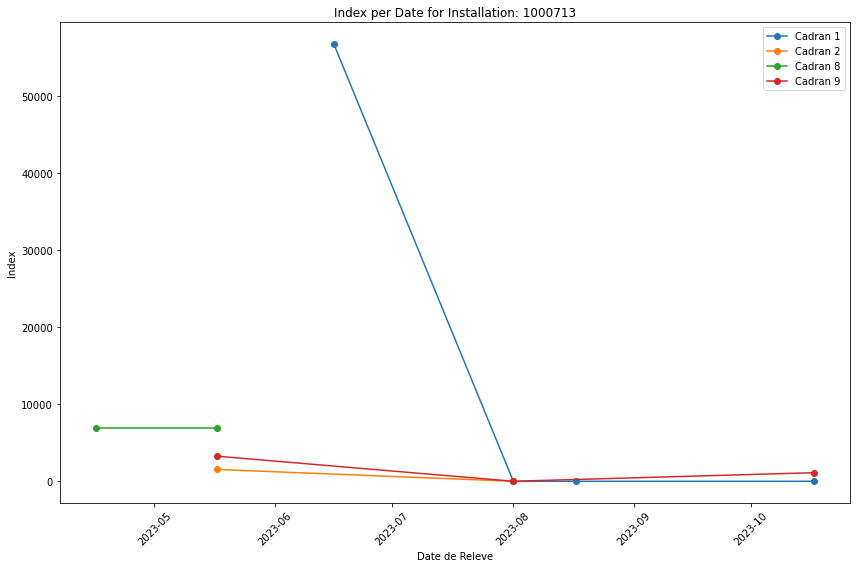

******************************
          Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
3475  4092261603  41036928500     2667027       1     2023-08-01      0       1000713    21D    6201Z  1000713_1           -100.00      46.00     -56789.00                  -2.17
------------------------------
 Releve 4294594704 and Cadran 1000744_8 and Installation 1000744


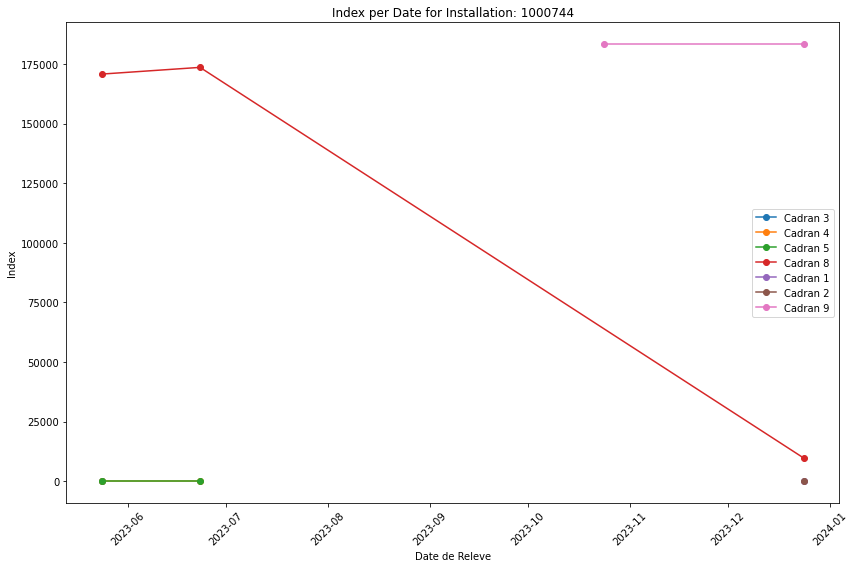

******************************
          Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
3726  4294594704  41036921614     2657171       8     2023-12-24   9714       1000744    094    0111Z  1000744_8            -94.40     184.00    -163873.00                  -0.51
------------------------------
 Releve 4306267417 and Cadran 1001146_1 and Installation 1001146


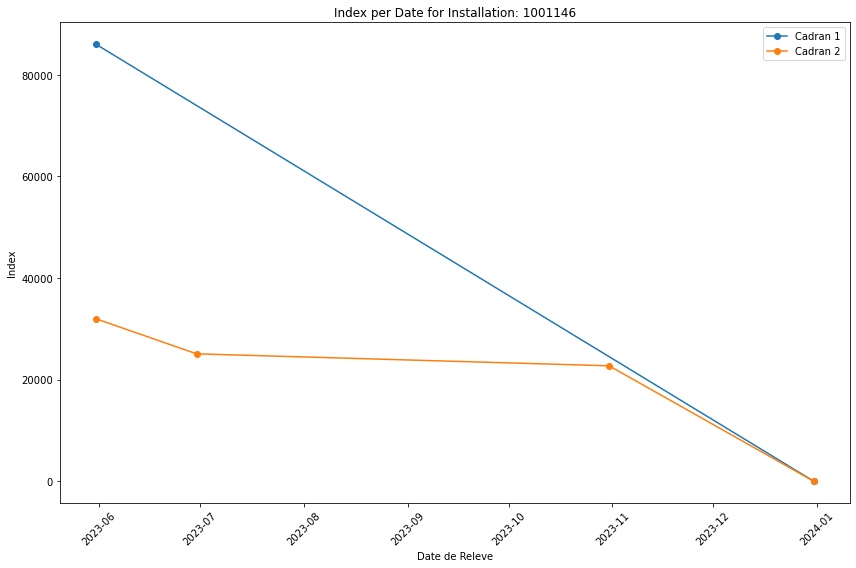

******************************
          Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
5093  4306267417  10000002056     1805608       1     2023-12-31     10       1001146    146    0113Z  1001146_1            -99.99     214.00     -85985.00                  -0.47
------------------------------
 Releve 4107488325 and Cadran 100177_8 and Installation 100177


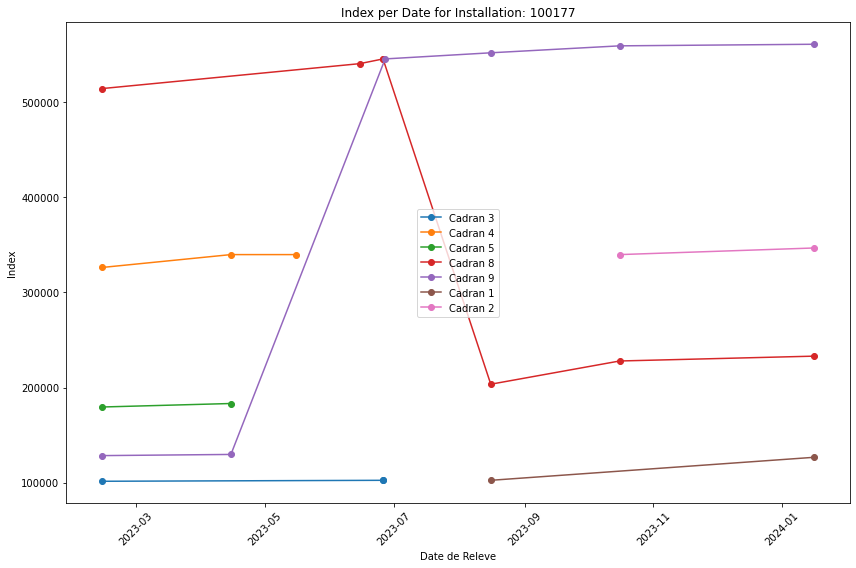

******************************
          Releve     Appareil  Equipement  Cadran Date_de_releve   Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
8060  4107488325  41036920847     2656777       8     2023-08-16  203498        100177    253    5629B   100177_8            -62.69      51.00    -341929.00                  -1.23
------------------------------
 Releve 4321389193 and Cadran 1002140_1 and Installation 1002140


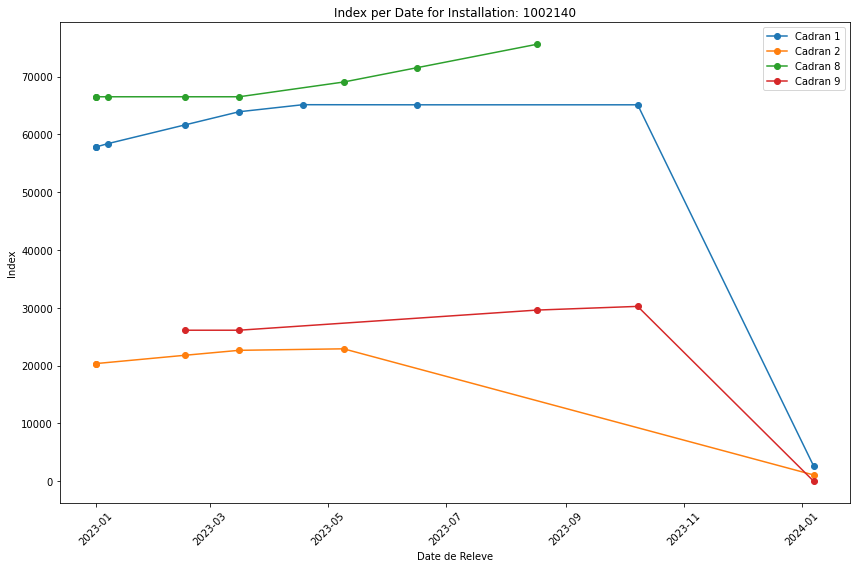

******************************
          Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
9298  4321389193  41036952088     2706634       1     2024-01-07   2614       1002140    22E    9499Z  1002140_1            -95.99      91.00     -62511.00                  -1.05
------------------------------
 Releve 3926743180 and Cadran 100290_2 and Installation 100290


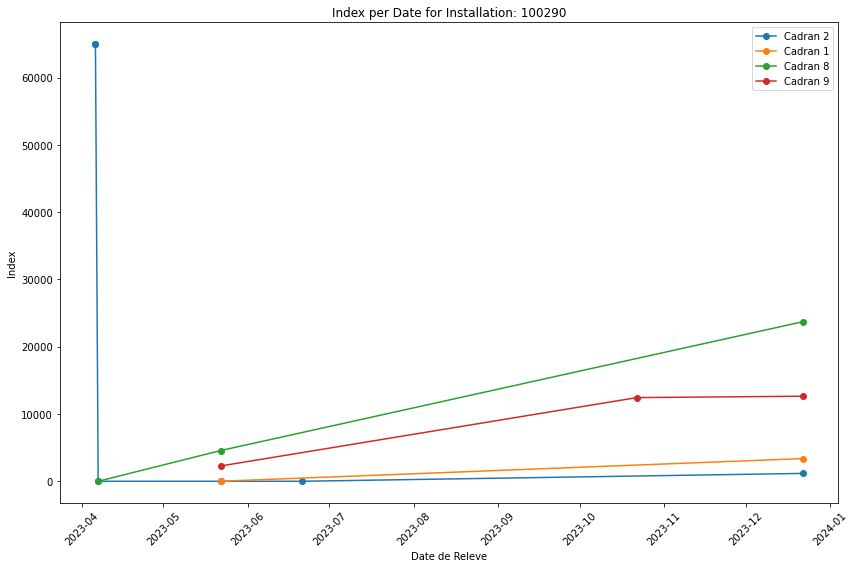

******************************
           Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
12850  3926743180  41036905650     2631338       2     2023-04-07      0        100290    121    8411Z   100290_2           -100.00       1.00     -64946.00                -100.00
------------------------------
 Releve 3926737828 and Cadran 1003202_1 and Installation 1003202


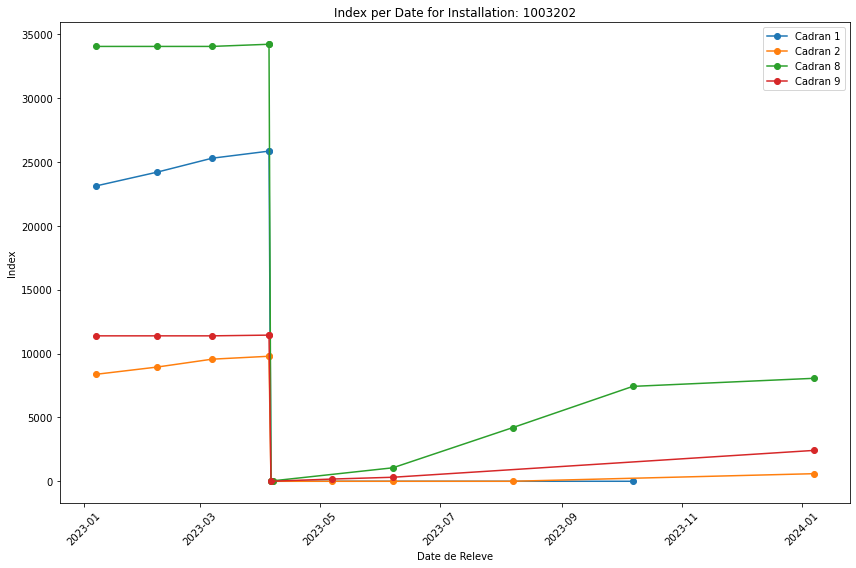

******************************
           Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
14342  3926737828  41036905585     2631299       1     2023-04-06      0       1003202    196    3315Z  1003202_1           -100.00       1.00     -25849.00                -100.00
------------------------------
 Releve 4306635015 and Cadran 100336_3 and Installation 100336


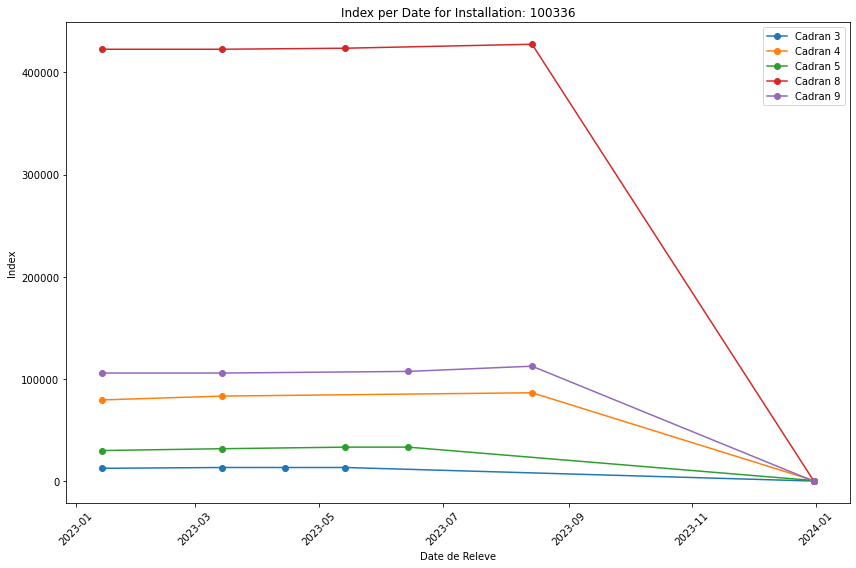

******************************
           Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
15154  4306635015  41036955795     2712741       3     2023-12-31    225        100336    234    0124Z   100336_3            -98.33     231.00     -13245.00                  -0.43
------------------------------
 Releve 3934969754 and Cadran 1003670_1 and Installation 1003670


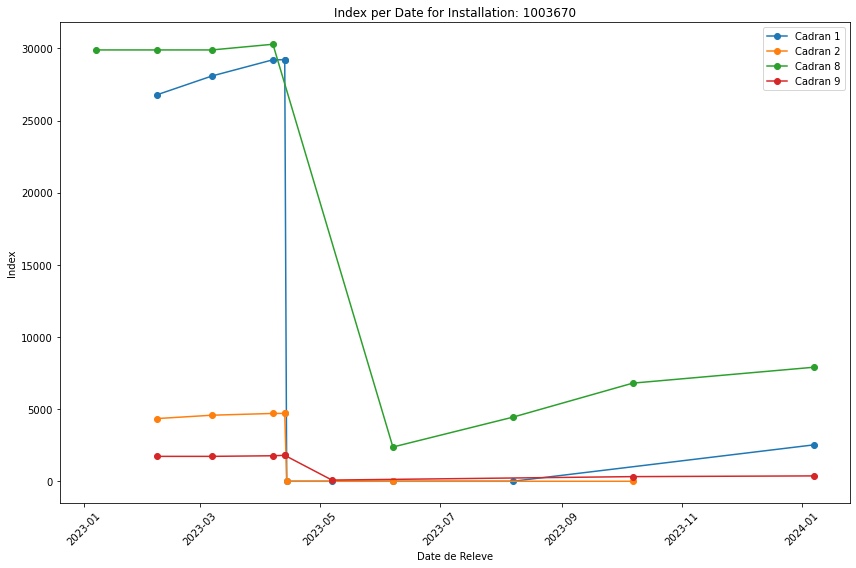

******************************
           Releve     Appareil  Equipement  Cadran Date_de_releve  Index  Installation Region Code_Naf Cadran_key  Index_pct_change  Time_diff  Index_change  Adjusted_Index_Change
16531  3934969754  41036906792     2633099       1     2023-04-14      0       1003670    195    4391A  1003670_1           -100.00       1.00     -29212.00                -100.00
------------------------------
done


In [137]:
# detect brutal change in a cadran
if anomalies_df is None:
    anomalies_df = get_anomalies()

consolidated_with_changes=get_aggregated_data_with_Adjusted_Index_Change()

if consolidated_with_changes is None:
    consolidated_with_changes=get_aggregated_data_with_Adjusted_Index_Change()

    
print(consolidated_with_changes.columns)
#significant_changes = consolidated_with_changes[(consolidated_with_changes['Adjusted_Index_Change'] < -1) & (~consolidated_with_changes['Time_diff'].isna())]

significant_changes = consolidated_with_changes[(consolidated_with_changes['Index_pct_change'] < -25)&(consolidated_with_changes['Index_change'] < -3000) & (~consolidated_with_changes['Time_diff'].isna())]

print(f'Nb significant_changes:{len(significant_changes)}')

added_installations=[]
max_nb= 10
nb = 0

for index, row in significant_changes.iterrows():
    if nb>max_nb:
        break
    
    # Access the Releve and Cadran_key values for the current row
    releve_value = int(row['Releve'])
    cadran_key_value = row['Cadran_key']
    installation_value = row['Installation']
    if installation_value in added_installations:
        continue
    nb+=1
    added_installations.append(installation_value)
    print(f' Releve {releve_value} and Cadran {cadran_key_value} and Installation {installation_value}')
    #plot_index_per_date_for_Cadran(consolidated_df,cadran_key_value)
    plot_index_per_date_for_installation(consolidated_df, installation_value)
    infos = get_releve_info(significant_changes,releve_value).to_string()
    print("*"*30)
    print(infos)
    print("-"*30)

found_anomalies=[]
for index, row in significant_changes.iterrows():
    releve_value = int(row['Releve'])
    infos = get_releve_info(anomalies_df,releve_value)
    if len(infos)>0:
        found_anomalies.append(releve_value)
        #print(infos)
filtered_df = anomalies_df[anomalies_df['Releve'].isin(found_anomalies)]

dataframe_to_csv(filtered_df,"found_anomalies.csv")
print("done")
    


In [ ]:
'''
5520Z: Hébergement touristique et autre hébergement de courte durée
'''

#Manual checks
'''
releve = 3887112992
infos = get_releve_info(significant_changes,releve)
print(infos)
Installation= infos['Installation'].iloc[0]
print(f'Installation {Installation}')
infos_ano = get_releve_info(anomalies_df,releve)
print(infos_ano)
'''

'''
head=filtered_df.head()
for index, row in filtered_df.iterrows():
    releve_value = int(row['Releve'])
    print(releve_value)
    infos = get_releve_info(significant_changes,releve_value)
    installation= infos['Installation'].iloc[0]
    plot_index_per_date_for_installation(consolidated_df, installation, f'installation_cadrans/{installation}.jpg')
'''





infos = get_releve_info(significant_changes,3887112991)
print(infos)
infos = get_releve_info(significant_changes,3887112992)
print(infos)

Code_Naf = infos['Code_Naf'].iloc[0]
installation= infos['Installation'].iloc[0]
print(f'Installation {Installation}')
plot_index_per_date_for_installation(consolidated_df, installation)

print(len(filtered_df))
print(len(anomalies_df))

print("done")


In [ ]:
# list appareil with average consumption >100 kwh
minaverage=100
aggregated_data_minimal = consolidated_df.groupby(['Appareil', 'Date_de_releve'], as_index=False)['Index'].sum().rename(columns={'Index': 'Aggregated_Index'})

# Step 2: Calculate the average Aggregated_Index for each Appareil
average_agg_index = aggregated_data_minimal.groupby('Appareil', as_index=False)['Aggregated_Index'].mean().rename(columns={'Aggregated_Index': 'Average_Aggregated_Index'})

# Filter out Appareils with an average Aggregated_Index below 100
filtered_appareils = average_agg_index[average_agg_index['Average_Aggregated_Index'] >= minaverage]
print(f"Nb filtered appareilsl: {len(filtered_appareils)}")

aggregated_data = consolidated_df[consolidated_df['Appareil'].isin(filtered_appareils['Appareil'])]


aggregated_data = aggregated_data.groupby(['Appareil', 'Date_de_releve'])['Index'].sum().reset_index(name='Aggregated_Index')

aggregated_data.sort_values(by=['Appareil', 'Date_de_releve'], inplace=True)

# Calculate the difference in days between successive Date_de_releve entries
aggregated_data['Time_diff'] = aggregated_data.groupby('Appareil')['Date_de_releve'].diff().dt.days

# Calculate the percentage change of the Index
print(aggregated_data.columns)
aggregated_data['Index_pct_change'] = aggregated_data.groupby('Appareil')['Aggregated_Index'].pct_change() * 100

# Adjust the Index Percentage Change by the Time Difference
aggregated_data['Adjusted_Index_Change'] = aggregated_data['Index_pct_change'] / aggregated_data['Time_diff']

# Filter for significant changes, adjust criteria as needed
significant_changes_per_apparel = aggregated_data[(aggregated_data['Index_pct_change'].abs() > 20) & (~aggregated_data['Time_diff'].isna())]

unique_appareils = significant_changes_per_apparel['Appareil'].unique()
print(f"Nb significant changes in Appareil: {len(unique_appareils)}")

In [ ]:
print(unique_appareils[:10])
plot_index_per_date_for_appareil(consolidated_df,10000000017  )

In [ ]:
df = consolidated_df
df.sort_values(by=['Appareil', 'Cadran', 'Date_de_releve'], inplace=True)

df['Index_pct_change'] = df.groupby(['Appareil', 'Cadran'])['Index'].pct_change()

# Calculate the mean of percentage changes for each Appareil and Cadran to reduce noise
mean_pct_changes = df.groupby(['Appareil', 'Cadran'])['Index_pct_change'].mean().reset_index()

# Pivot to have each Cadran's mean percentage change as a column
pivot_mean_pct_changes = mean_pct_changes.pivot(index='Appareil', columns='Cadran', values='Index_pct_change')

# Calculate the variance of these mean percentage changes across Cadrans for each Appareil
pivot_mean_pct_changes['variance_across_cadrans'] = pivot_mean_pct_changes.var(axis=1)

# Define a threshold for significant variance
threshold = 0.5  # Adjust this based on your data and requirements

# Find Appareils with variance above the threshold
significant_variance_appareils = pivot_mean_pct_changes[pivot_mean_pct_changes['variance_across_cadrans'] > threshold]


In [ ]:
print(significant_variance_appareils)


# Fitting

Index(['Releve', 'Appareil', 'Equipement', 'Cadran', 'Date_de_releve', 'Index',
       'Installation', 'Region', 'Code_Naf', 'Cadran_key', 'Reduced_Naf'],
      dtype='object')
             Releve  Appareil  Equipement  Cadran Date_de_releve   Index  \
4792271  3985519560       104        7510       1     2023-05-22  300124   
9227486  4293081155       104        7510       1     2023-12-22  303474   
9227487  4293081156       104        7510       2     2023-12-22  153059   
9227488  4293081157       104        7510       8     2023-12-22  255498   
5922084  4028311309       104        7510       9     2023-06-21   99793   

         Installation Region Code_Naf Cadran_key Reduced_Naf  
4792271         12957    122    4669C    12957_1         466  
9227486         12957    122    4669C    12957_1         466  
9227487         12957    122    4669C    12957_2         466  
9227488         12957    122    4669C    12957_8         466  
5922084         12957    122    4669C    12957_9   

/var/folders/7v/cgc6db_s0jg20l4ckkkc8s7w0000gn/T/ipykernel_85892/1675598007.py:37: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  filtered_df['Semaine_de_releve'] = filtered_df['Date_de_releve'].dt.week


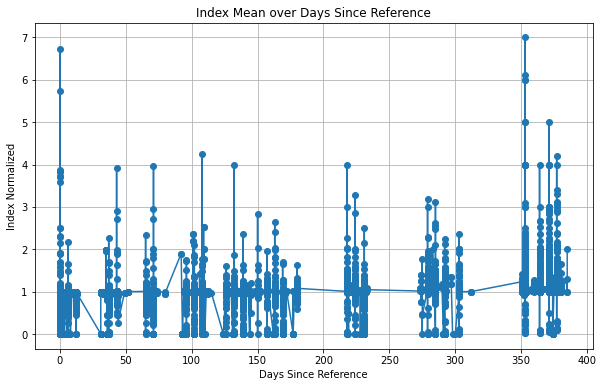

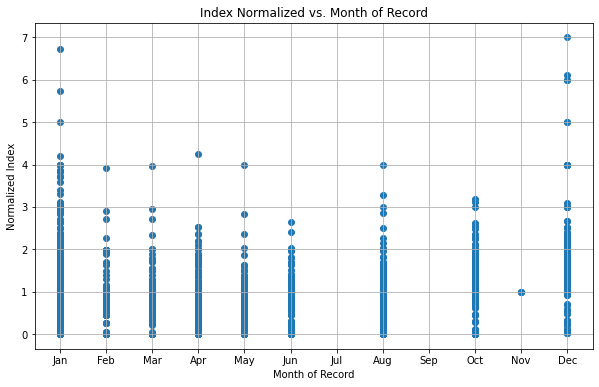

In [172]:
print (consolidated_df.columns)
print (consolidated_df.head())
consolidated_df['Reduced_Naf'] = consolidated_df['Code_Naf'].astype(str).str[:3]
#consolidated_df['Codepost2'] = consolidated_df['Codepost.'].astype(str).str[:2]
#122
#consolidated_with_changes
#let's extract most common Reduced_Naf and Codepost2

print(consolidated_df.nunique())
region_counts = consolidated_df['Region'].value_counts()
naf_counts = consolidated_df['Reduced_Naf'].value_counts()


most_common_Naf =consolidated_df['Reduced_Naf'].mode()[0]
most_common_Codepost2 =consolidated_df['Region'].mode()[0]


second_most_common_region = region_counts.index[1]
second_most_common_naf = naf_counts.index[1]

print(f'Choosing for test {second_most_common_naf} and {second_most_common_region}')

filtered_df = consolidated_df[(consolidated_df['Reduced_Naf'] == most_common_Naf) & (consolidated_df['Region'] == most_common_Codepost2)]

columns_to_drop=['Appareil', 'Equipement', 'Cadran','Code_Naf', 'Installation']
filtered_df = drop_columns(filtered_df,columns_to_drop)

filtered_df['Index_mean'] = filtered_df.groupby('Cadran_key')['Index'].transform('mean')



filtered_df['Index_normalized'] = filtered_df['Index'] / filtered_df['Index_mean']

filtered_df = filtered_df.dropna(subset=['Index_normalized'])

filtered_df['Mois_de_releve'] = filtered_df['Date_de_releve'].dt.month
filtered_df['Semaine_de_releve'] = filtered_df['Date_de_releve'].dt.week

reference_date = pd.Timestamp('2023-01-01')
filtered_df['DaysSinceReference'] = (filtered_df['Date_de_releve'] - reference_date).dt.days

columns_to_drop=[ 'Date_de_releve']
filtered_df = drop_columns(filtered_df,columns_to_drop)
print(filtered_df.columns)

sorted_df = filtered_df.sort_values(by='DaysSinceReference')
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
plt.plot(sorted_df['DaysSinceReference'], sorted_df['Index_normalized'], marker='o', linestyle='-')
plt.title('Index Mean over Days Since Reference')  # Optional: Adds a title to the plot
plt.xlabel('Days Since Reference')  # Optional: Adds a label to the x-axis
plt.ylabel('Index Normalized')  # Optional: Adds a label to the y-axis
plt.grid(True)  # Optional: Adds a grid for better readability
plt.show()


sorted_df = sorted_df.sort_values(by='Mois_de_releve')
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.scatter(sorted_df['Mois_de_releve'], sorted_df['Index_normalized'])

plt.title('Index Normalized vs. Month of Record')  # Add a title
plt.xlabel('Month of Record')  # Add an x-label
plt.ylabel('Normalized Index')  # Add a y-label
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Optional: Set custom x-axis tick labels

plt.grid(True)  # Add a grid for better readability
plt.show()



(41120, 1)
NaN values in X:
Semaine_de_releve    False
dtype: bool

NaN values in y: False

Rows with NaN in y:
Series([], Name: Index_normalized, dtype: float64)


/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


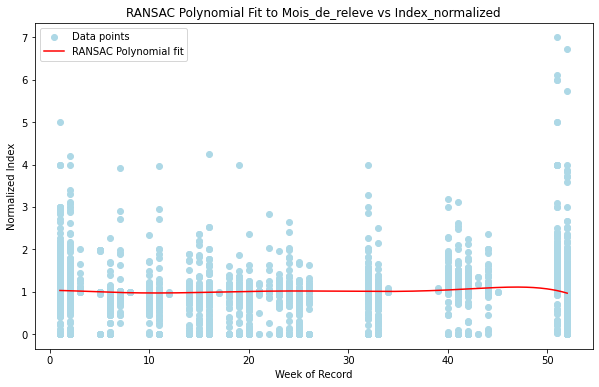

/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


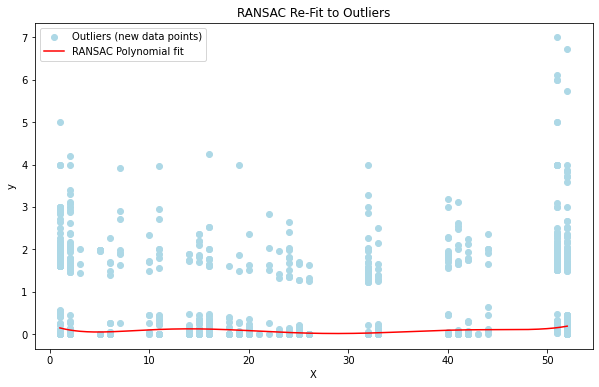

/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


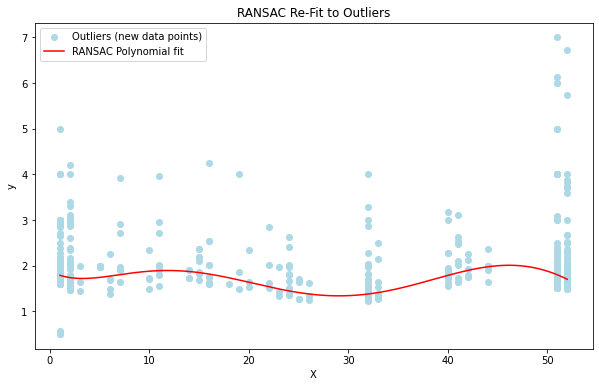

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

df = sorted_df
# Assuming df is your DataFrame with 'Mois_de_releve' and 'Index_normalized'
X = df[['Semaine_de_releve']]  # Needs to be 2D for sklearn
y = df['Index_normalized']

print(X.shape)
nan_in_X = X.isna().any()
print("NaN values in X:")
print(nan_in_X)

nan_in_y = y.isna().any()
print("\nNaN values in y:", nan_in_y)

rows_with_nan_in_y = y[y.isna()]
print("\nRows with NaN in y:")
print(rows_with_nan_in_y)

degree = 6  # Degree of the polynomial to fit
ransac = make_pipeline(PolynomialFeatures(degree), RANSACRegressor(random_state=42,residual_threshold=0.5))

ransac.fit(X, y)

X_pred = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)  # Generating points to predict and plot
y_pred = ransac.predict(X_pred)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='lightblue', label='Data points')
plt.plot(X_pred, y_pred, color='red', label='RANSAC Polynomial fit')
plt.xlabel('Week of Record')
plt.ylabel('Normalized Index')
plt.title('RANSAC Polynomial Fit to Mois_de_releve vs Index_normalized')
plt.legend()
plt.show()

inlier_mask = ransac.named_steps['ransacregressor'].inlier_mask_
# For the X data, assuming it's a DataFrame or 2D numpy array
X_outliers = X[~inlier_mask]
y_outliers = y[~inlier_mask]
ransac.fit(X_outliers, y_outliers)
# Predict with the new model
X_pred = np.linspace(X_outliers.min(), X_outliers.max(), 300).reshape(-1, 1)  # Adjust as necessary
y_pred = ransac.predict(X_pred)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_outliers, y_outliers, color='lightblue', label='Outliers (new data points)')
plt.plot(X_pred, y_pred, color='red', label='RANSAC Polynomial fit')
plt.xlabel('X')
plt.ylabel('y')
plt.title('RANSAC Re-Fit to Outliers')
plt.legend()
plt.show()

inlier_mask = ransac.named_steps['ransacregressor'].inlier_mask_
# For the X data, assuming it's a DataFrame or 2D numpy array
X_outliers_2 = X_outliers[~inlier_mask]
y_outliers_2 = y_outliers[~inlier_mask]
ransac.fit(X_outliers_2, y_outliers_2)
# Predict with the new model
X_pred = np.linspace(X_outliers_2.min(), X_outliers_2.max(), 300).reshape(-1, 1)  # Adjust as necessary
y_pred = ransac.predict(X_pred)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_outliers_2, y_outliers_2, color='lightblue', label='Outliers (new data points)')
plt.plot(X_pred, y_pred, color='red', label='RANSAC Polynomial fit')
plt.xlabel('X')
plt.ylabel('y')
plt.title('RANSAC Re-Fit to Outliers')
plt.legend()
plt.show()



# Utils to draw some graphs

In [ ]:
#many graphs
def draw_categorical_plot(data, figsize=(8, 6), colors=None):
    if not isinstance(data, pd.Series):
        print(data.name+":ignoring because not a categorical data")
        return
        #raise ValueError("Input data should be a categorical data.")

    # Count the occurrences of each category in the data
    nb_unique_values = data.nunique()

    if nb_unique_values>100 and  nb_unique_values/data.count()>0.7:
      print(data.name+":looks like a key, returning")
      return

    if(nb_unique_values>ENV.nb_binning_limit):
      print(data.name+":too many unique values, binning")
      plt.figure(figsize=(10, 6))
      sns.histplot(data, bins=ENV.nb_binning_limit, kde=False)

      plt.title('Histogram of '+data.name+' with '+str(ENV.nb_binning_limit)+' Bins')
      plt.xlabel(data.name)
      plt.ylabel('Frequency')

      plt.show()
      return

    counts = data.value_counts()

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # If there are less than 6 unique observations, draw a pie chart
    if len(counts) <= 5:
        counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, ax=ax)
        ax.set_title("Pie Chart of " + data.name)
        ax.set_ylabel("")  # This is to remove the column name from the side of the pie chart
    else:
        # Otherwise, draw a bar chart
        sns.barplot(x=counts.index, y=counts.values, palette=colors, ax=ax)
        ax.set_title("Bar Chart of " + data.name)
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()  # Display the plot

    
if ENV.show_graphs:
  for column in consolidated_df.columns:
    draw_categorical_plot(consolidated_df[column])

#columns_to_consider=df.columns#['HomePlanet','Destination','CryoSleep','VIP','Age','RoomService','FoodCourt','ShoppingMall','Spa','Transported']
